# HW2 - Excel work w/ Python

In this homework assignment, we will be performing Excel work through Python using OO models, datatables, goal_seek, and wrangling of data.

* link to [video](https://www.youtube.com/watch?v=dLCGAuiJ1U0) for assignment overview
* analysis 1 con be done in conjustion with the What-if analysis with python module

## Preliminaries

In [7]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection._search import ParameterGrid
import copy
from pathlib import Path
import os
from glob import glob
from openpyxl import Workbook
from openpyxl import load_workbook
import openpyxl
import csv

In [11]:
%matplotlib inline

# Analysis 1

## 1a - Create Base Model

First we will need to import the things we need from the whatif module

In [16]:
from whatif import Model
from whatif import get_sim_results_df

Here, we have created the various formulas and fucntions for creating our base model. Formulas include; 
* demand
* production cost
* total cost
* sales revenue
* and profit

In [187]:
class SingleProductSPF(Model):
    """HW2 Model"""
    def __init__(self, fixed_cost=5000, var_cost=100, selling_price=115, 
                 spf_constant=4900, spf_linear=-35, spf_quadratic=0.06):
        self.fixed_cost = fixed_cost
        self.var_cost = var_cost
        self.selling_price = selling_price
        self.spf_constant = spf_constant
        self.spf_linear = spf_linear
        self.spf_quadratic = spf_quadratic

    def demand(self):
        """Computing Demand"""
        demand = self.spf_quadratic * self.selling_price**2 + self.spf_linear * self.selling_price + self.spf_constant
        return demand

    def production_cost(self):
        """Computing the cost to produce the product"""
        production_cost = self.var_cost * self.demand()
        return production_cost

    def total_cost(self):
        """Computing the total cost of everything"""
        total_cost = self.production_cost() + self.fixed_cost
        return total_cost
    
    def sales_revenue(self):
        """Compute sales revenue"""
        sales_revenue = self.selling_price * self.demand()
        return sales_revenue
    
    def profit(self):
        """Compute profit"""
        profit = self.sales_revenue() - self.total_cost()
        return profit

In [189]:
model = SingleProductSPF()
print(model)

{'fixed_cost': 5000, 'var_cost': 100, 'selling_price': 115, 'spf_constant': 4900, 'spf_linear': -35, 'spf_quadratic': 0.06}


Checking to see if demand and profit are correct based on the info in the hw. 

In [192]:
print(model.demand())
print(model.profit())
print(model.total_cost())
print(model.production_cost())

1668.5
20027.5
171850.0
166850.0


Calculations and formulations were correct!

## 1b - One-way Data Table

We are now specifiying the range for our input, which is `selling_price`, and the outputs, `profit` and `demand` for our 1-way data table. Then we will plug in our scenario_inputs and outputs in the datatable function provided by our model.

In [165]:
# Specifying input ranges between $80 and $140
dt_param_range1 = {'selling_price': np.arange(80, 141, 10)}

# specifying output
outputs = ['profit', 'demand']

In [167]:
# Creation of 1-way data table
model_dt1 = model.data_table(dt_param_range1, outputs)
model_dt1

,selling_price,profit,demand
0,80,-54680.0,2484.0
1,90,-27360.0,2236.0
2,100,-5000.0,2000.0
3,110,12760.0,1776.0
4,120,26280.0,1564.0
5,130,35920.0,1364.0
6,140,42040.0,1176.0


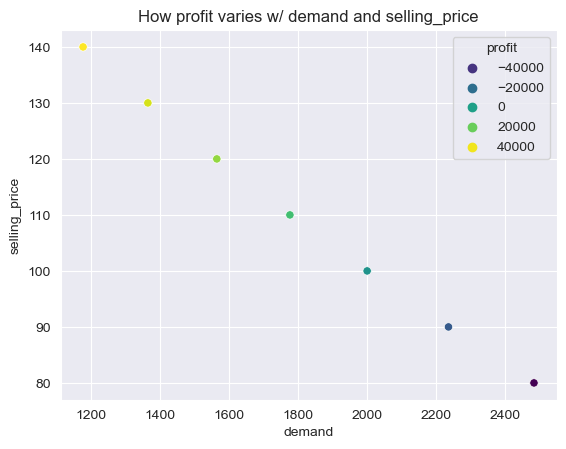

In [34]:
sns.set_style("darkgrid")
sns.scatterplot(x="demand", y="selling_price", hue="profit", data=model_dt1, palette="viridis").set(title='How profit varies w/ demand and selling_price');

**Explanation:** Here is a graphical represantation of our 1-way data table. As we can see, it seems like our break even profit is somewhere at a selling price of 100 and a demand of around 2000. The shape of this relationship is a linear one. It has this shape because we are comparing two quantites against each other, the selling price and profit. 

## 1c - Break Even

In [40]:
model_dt1

,selling_price,profit,demand
0,80,-54680.0,2484.0
1,90,-27360.0,2236.0
2,100,-5000.0,2000.0
3,110,12760.0,1776.0
4,120,26280.0,1564.0
5,130,35920.0,1364.0
6,140,42040.0,1176.0


In [42]:
# Specifying input ranges
dt_param_range1 = {'selling_price': np.arange(80, 141, 10)}

# specifying output
outputs = ['profit', 'demand']

model_goal_dt1 = model.goal_seek('profit', 0, 'selling_price', 80, 141, 1000)
print(f"The Break Even point for this scenario is for selling price to be at: {model_goal_dt1}")

The Break Even point for this scenario is for selling price to be at: 102.57578606424767


Interesting enough, if we plug that Break even point into our model instead of $115, we can rerun it and the profit will produce 0.

In [44]:
# # Initialize plot
# plt.style.use('ggplot')
# fig, ax = plt.subplots()

# # Create series variables
# demand = np.array(model_goal_dt1['demand'])
# selling_price = np.array(model_goal_dt1['selling_price'])
# profit = np.array(model_goal_dt1['profit'])

# # Plot series
# ax.plot(demand, selling_price, label='Selling__Price')
# ax.plot(demand, profit, label='Profit')

# # Style plot elements
# ax.set(title='Break even analysis for bookstore model', xlabel='Demand', ylabel='$')
# plt.hlines(0, 70, 320, linestyles='dotted')
# plt.vlines(break_even_demand, -750, 2000, linestyles='dotted')
# ax.legend(loc='lower right')

# # Show the plot
# plt.show()

## 1d - Two-way Data Table

Here we are attempting to create a 2-way data table with the sensitivity of profit and total cost agaisnt seling price and variable production cost. 

In [176]:
# Specifying input ranges between $80 and $140 for selling_price and $85 to $110 for variable production cost
dt_param_range2 = {'selling_price': np.arange(80, 141, 10),
                  'var_cost': np.arange(85, 111, 5)}

# specifying output
outputs = ['profit', 'total_cost']

# Creation of 2-way data table
model_dt2 = model.data_table(dt_param_range2, outputs)
model_dt2

,selling_price,var_cost,profit,total_cost
0,80,85,-17420.0,216140.0
1,80,90,-29840.0,228560.0
2,80,95,-42260.0,240980.0
3,80,100,-54680.0,253400.0
4,80,105,-67100.0,265820.0
5,80,110,-79520.0,278240.0
6,90,85,6180.0,195060.0
7,90,90,-5000.0,206240.0
8,90,95,-16180.0,217420.0
9,90,100,-27360.0,228600.0


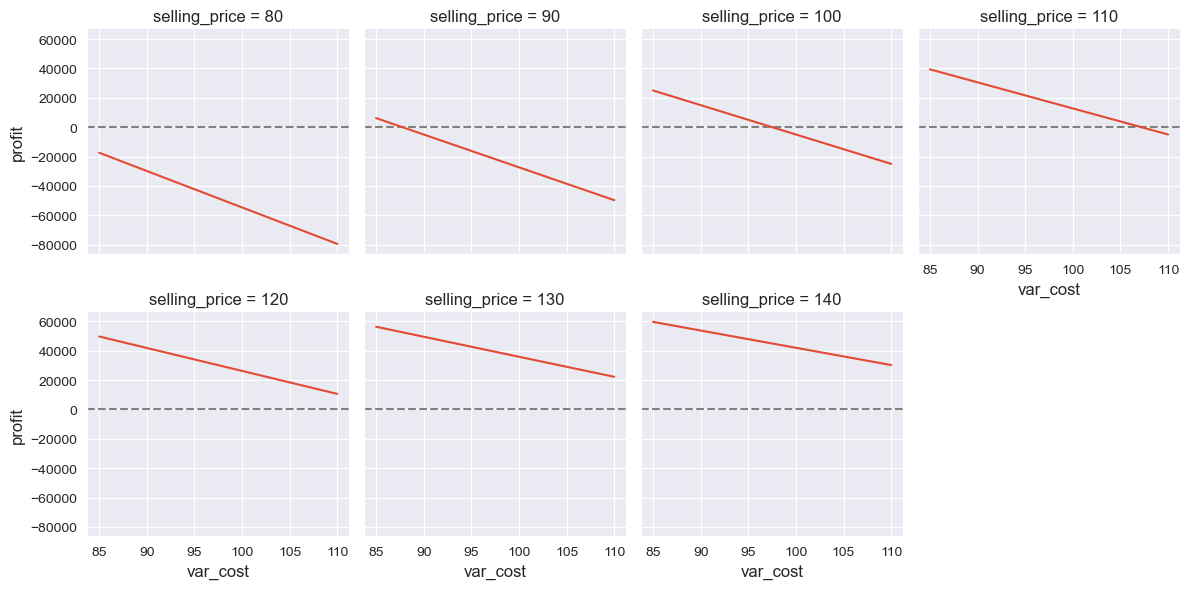

In [214]:
profit_dt_g = sns.FacetGrid(model_dt2, col="selling_price", sharey=True, col_wrap=4).refline(y=0)
profit_dt2 = profit_dt_g.map(plt.plot, "var_cost", "profit")

**Explanation:** After looking at the 2-way data table visuals it seems that the higher the selling_price goes the higher the var_cost goes in order to achive a profit of zero. For example, if you have a selling price of 100, then you may reach a profit of zero with a variable cost of 96 dollars. But if you have a selling price of 110, then you may reach a profit of zero with a variable cost of around 105 dollars.

In [210]:
# # Initialize plot
# plt.style.use('ggplot')
# fig, ax = plt.subplots()

# # Create series variables
# total_cost = np.array(model_dt2['total_cost'])
# var_cost = np.array(model_dt2['var_cost'])
# selling_price = np.array(model_dt2['selling_price'])
# profit = np.array(model_dt2['profit'])

# # Plot series
# #ax.plot(selling_price, total_cost, label='Total cost')
# ax.plot(var_cost, profit, label='Total var cost')
# ax.plot(selling_price, profit, label='Profit')

# # # Style plot elements
# # ax.set(title='Break even analysis for bookstore model', xlabel='Demand', ylabel='$')
# plt.hlines(0, 70, 320, linestyles='dotted')
# #plt.vlines(break_even_demand, -750, 2000, linestyles='dotted')
# ax.legend(loc='lower right')

# # Show the plot
# plt.show()

In [198]:
# model_goal1_dt2 = model.goal_seek('profit', 0, 'selling_price', 80, 141, 1000)
# model_goal2_dt2 = model.goal_seek('total_cost', 0, 'selling_price', 80, 141, 1000)
# model_goal3_dt2 = model.goal_seek('profit', 0, 'var_cost', 85, 111, 1000)
# model_goal4_dt2 = model.goal_seek('total_cost', 0, 'var_cost', 85, 111, 1000)
# print(f"The Break Even point for this scenario is for selling price to be at: {model_goal1_dt2}")
# print(f"The Break Even point for this scenario is for selling price to be at: {model_goal2_dt2}")
# print(f"The Break Even point for this scenario is for selling price to be at: {model_goal3_dt2}")
# print(f"The Break Even point for this scenario is for selling price to be at: {model_goal4_dt2}")

## 1e - Digging Deeper

In [222]:
# Specifying new input range
dt_param_range3 = {'selling_price': np.arange(80, 251, 10)}

# specifying output
outputs = ['profit', 'demand']

# Creation of 1-way data table
model_dt1_again = model.data_table(dt_param_range3, outputs)
model_dt1_again

,selling_price,profit,demand
0,80,-54680.0,2484.0
1,90,-27360.0,2236.0
2,100,-5000.0,2000.0
3,110,12760.0,1776.0
4,120,26280.0,1564.0
5,130,35920.0,1364.0
6,140,42040.0,1176.0
7,150,45000.0,1000.0
8,160,45160.0,836.0
9,170,42880.0,684.0


In [59]:
# Specifying input ranges
dt_param_range3 = {'selling_price': np.arange(80, 251, 10)}

# specifying output
outputs = ['profit', 'demand']

model_goal_extra = model.goal_seek('profit', 0, 'selling_price', 80, 251, 1000)
print(f"The Break Even point for this scenario is for selling price to be at: {model_goal_extra}")

The Break Even point for this scenario is for selling price to be at: None


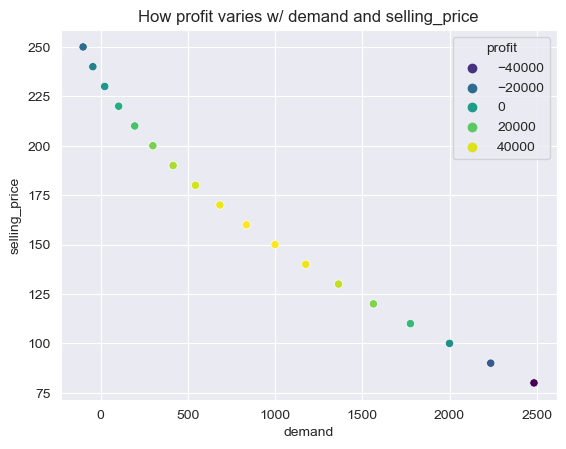

In [61]:
sns.set_style("darkgrid")
sns.scatterplot(x="demand", y="selling_price", hue="profit", data=model_dt1_again, palette="viridis").set(title='How profit varies w/ demand and selling_price');

**Explanation:** It seems as soon as demand reaches around 2,000, it continues to decrease as selling price increases. Which then leads to two different break even points. And with that it soon leads to almost zero demand in our data table and goal seek visuals.

## 1f - Simulation

In [65]:
from numpy.random import default_rng
rg = default_rng(4470)

In [67]:
num_reps = 100

random_inputs = {'var_cost': rg.uniform(80, 120, num_reps)}

scenario_inputs = {'selling_price': np.arange(80, 141, 10)}

sim_outputs = ['profit']

In [69]:
model_simulate = model.simulate(random_inputs, sim_outputs, scenario_inputs)

In [71]:
def get_sim_results_df(results):
    
    dfs = []    
    for r in results:
        df = pd.DataFrame(r['output'])
        df['scenario_num'] = r['scenario_num']
        for key, val in r['scenario_vals'].items():
            df[key] = val
            
        dfs.append(df)

    results_df = pd.concat(dfs)
    
    return results_df

In [73]:
model_results_df = get_sim_results_df(model_simulate)

In [75]:
model_results_df

,profit,scenario_num,selling_price
0,-50562.327290,0,80
1,-19925.613514,0,80
2,-26051.175350,0,80
3,-39043.526957,0,80
4,-97835.214506,0,80
...,...,...,...
95,53903.957141,6,140
96,64067.062224,6,140
97,49326.568539,6,140
98,24750.973733,6,140


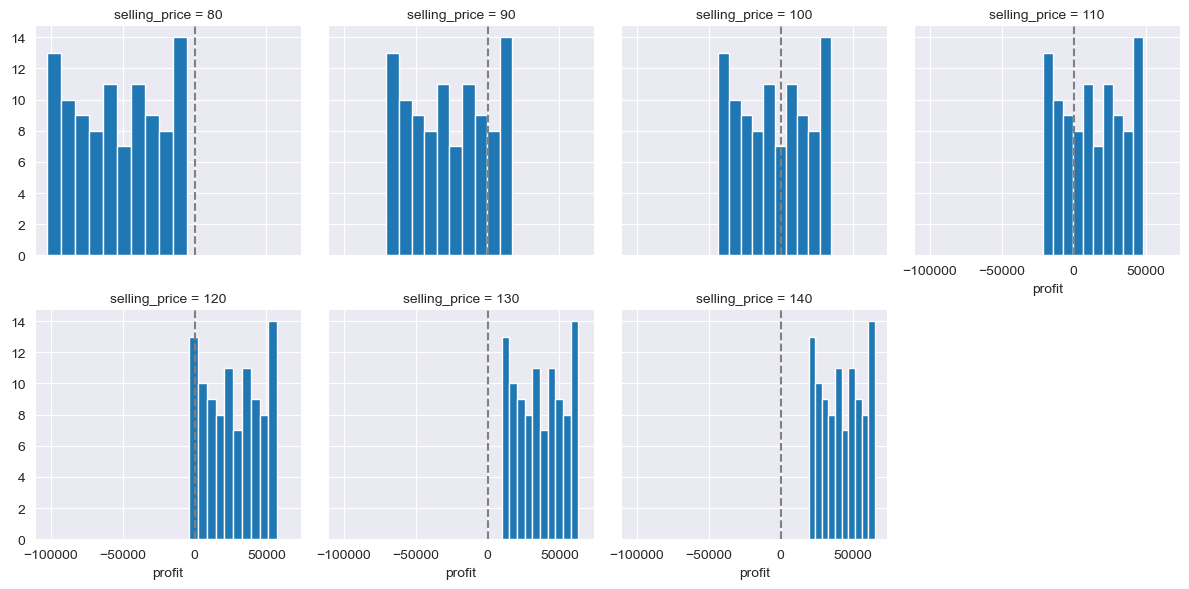

In [77]:
profit_histo_g2 = sns.FacetGrid(model_results_df, col='selling_price', sharey=True, col_wrap=4).refline(x=0)
profit_histo_g2 = profit_histo_g2.map(plt.hist, "profit")

In [233]:
from scipy import stats
print(stats.percentileofscore(profit, 0) / 100.0)

0.35714285714285715


**Explanation:** As we can see based on out visuals and our quick calculations, we can determine that the probability of a profit that is negative is around 0.36 or around 36%.

# Analysis 2

In [81]:
# Retrieve current working directory (`cwd`)
cwd = os.getcwd()
print(cwd)
print(type(cwd))

# List all files and directories in data directory
print(os.listdir("./data/logs"))

# Use glob to get all the csv filenames
for csv_fn in glob("./data/logs/*.csv"):
    print(csv_fn)

C:\Users\22nic\OneDrive\Documents\OU-summer24\hw-files\hw2_excel_withpython
<class 'str'>
['.ipynb_checkpoints', 'BCM-E-tCenter-Deep.csv', 'BCM-E-tCenter-Medium.csv', 'BCM-E-tCenter-Shallow.csv', 'BCM-E-tLeft-Deep.csv', 'BCM-E-tLeft-Medium.csv', 'BCM-E-tRight-Deep.csv', 'BCM-E-tRight-Medium.csv', 'BCM-N-tCenter-Deep.csv', 'BCM-N-tCenter-Medium.csv', 'BCM-N-tLeft-Deep.csv', 'BCM-N-tLeft-Medium.csv', 'BCM-N-tRight-Deep.csv', 'BCM-N-tRight-Medium.csv', 'BCM-N-tRight-Shallow.csv']
./data/logs\BCM-E-tCenter-Deep.csv
./data/logs\BCM-E-tCenter-Medium.csv
./data/logs\BCM-E-tCenter-Shallow.csv
./data/logs\BCM-E-tLeft-Deep.csv
./data/logs\BCM-E-tLeft-Medium.csv
./data/logs\BCM-E-tRight-Deep.csv
./data/logs\BCM-E-tRight-Medium.csv
./data/logs\BCM-N-tCenter-Deep.csv
./data/logs\BCM-N-tCenter-Medium.csv
./data/logs\BCM-N-tLeft-Deep.csv
./data/logs\BCM-N-tLeft-Medium.csv
./data/logs\BCM-N-tRight-Deep.csv
./data/logs\BCM-N-tRight-Medium.csv
./data/logs\BCM-N-tRight-Shallow.csv


In [83]:
Path.cwd()

WindowsPath('C:/Users/22nic/OneDrive/Documents/OU-summer24/hw-files/hw2_excel_withpython')

In [85]:
data_dir = Path.cwd() / "data"
data_dir

WindowsPath('C:/Users/22nic/OneDrive/Documents/OU-summer24/hw-files/hw2_excel_withpython/data')

In [87]:
data_dir.rglob('*.csv')

<generator object Path.rglob at 0x000002804B7DB120>

In [89]:
for f in data_dir.rglob('*.csv'):
    print(f)

C:\Users\22nic\OneDrive\Documents\OU-summer24\hw-files\hw2_excel_withpython\data\BCM.csv
C:\Users\22nic\OneDrive\Documents\OU-summer24\hw-files\hw2_excel_withpython\data\.ipynb_checkpoints\BCM-checkpoint.csv
C:\Users\22nic\OneDrive\Documents\OU-summer24\hw-files\hw2_excel_withpython\data\logs\BCM-E-tCenter-Deep.csv
C:\Users\22nic\OneDrive\Documents\OU-summer24\hw-files\hw2_excel_withpython\data\logs\BCM-E-tCenter-Medium.csv
C:\Users\22nic\OneDrive\Documents\OU-summer24\hw-files\hw2_excel_withpython\data\logs\BCM-E-tCenter-Shallow.csv
C:\Users\22nic\OneDrive\Documents\OU-summer24\hw-files\hw2_excel_withpython\data\logs\BCM-E-tLeft-Deep.csv
C:\Users\22nic\OneDrive\Documents\OU-summer24\hw-files\hw2_excel_withpython\data\logs\BCM-E-tLeft-Medium.csv
C:\Users\22nic\OneDrive\Documents\OU-summer24\hw-files\hw2_excel_withpython\data\logs\BCM-E-tRight-Deep.csv
C:\Users\22nic\OneDrive\Documents\OU-summer24\hw-files\hw2_excel_withpython\data\logs\BCM-E-tRight-Medium.csv
C:\Users\22nic\OneDrive\Do

In [285]:
wb = Workbook()
ws = wb.active

In [287]:
for f in log_path.glob('*.csv'):
    print(f"filename = {f.name}, stem = {f.stem}, suffix = {f.suffix}")
    startrow = writer.book[fstem].max_row
    print(f"Last row of data: {startrow}")

filename = BCM-E-tCenter-Deep.csv, stem = BCM-E-tCenter-Deep, suffix = .csv
Last row of data: 1005
filename = BCM-E-tCenter-Medium.csv, stem = BCM-E-tCenter-Medium, suffix = .csv
Last row of data: 1005
filename = BCM-E-tCenter-Shallow.csv, stem = BCM-E-tCenter-Shallow, suffix = .csv
Last row of data: 1005
filename = BCM-E-tLeft-Deep.csv, stem = BCM-E-tLeft-Deep, suffix = .csv
Last row of data: 1005
filename = BCM-E-tLeft-Medium.csv, stem = BCM-E-tLeft-Medium, suffix = .csv
Last row of data: 1005
filename = BCM-E-tRight-Deep.csv, stem = BCM-E-tRight-Deep, suffix = .csv
Last row of data: 1005
filename = BCM-E-tRight-Medium.csv, stem = BCM-E-tRight-Medium, suffix = .csv
Last row of data: 1005
filename = BCM-N-tCenter-Deep.csv, stem = BCM-N-tCenter-Deep, suffix = .csv
Last row of data: 1005
filename = BCM-N-tCenter-Medium.csv, stem = BCM-N-tCenter-Medium, suffix = .csv
Last row of data: 1005
filename = BCM-N-tLeft-Deep.csv, stem = BCM-N-tLeft-Deep, suffix = .csv
Last row of data: 1005
file

In [288]:
# Inputs
log_path = Path.cwd() / 'data' / 'logs'
# dest_path = Path.cwd() / 'data' / 'BCM.xlsx'
dest_path = str(Path('data', 'BCM.xlsx'))

# Create empty dict to hold the DataFrames created as we read each csv file
dfs = {}

# Loop over all the csv files 
for csv_f in log_path.glob('*.csv'):
    # Split the filename off from csv extension. We'll use the filename
    # (without the extension) as the key in the dfs dict.
    fstem = csv_f.stem
    print(fstem)

    # Read the next csv file into a pandas DataFrame and add it to
    # the dfs dict.
    df = pd.read_csv(csv_f)
    df = pd.read_csv(csv_f, names=['datetime','scale','temperature'])
    dfs[fstem] = df


    with pd.ExcelWriter(dest_path, engine = "openpyxl", mode = 'w') as writer:
        dfs[fstem].to_excel(writer, sheet_name = fstem, index = False)

# dfs[fstem].to_csv(dest_path, index=False)   


    
# # Export the final DataFrame to a csv file. Suppress the pandas index.

    
    
# writer = pd.ExcelWriter(dest_path, engine="xlsxwriter")    
    
    
#     #df.to_excel(writer, sheet_name = fstem)
# df.to_csv(dest_path, index=False)
#     # dfs[fstem] = df
#     # dfs[fstem].to_excel(writer, sheet_name = fstem)

BCM-E-tCenter-Deep
BCM-E-tCenter-Medium
BCM-E-tCenter-Shallow
BCM-E-tLeft-Deep
BCM-E-tLeft-Medium
BCM-E-tRight-Deep
BCM-E-tRight-Medium
BCM-N-tCenter-Deep
BCM-N-tCenter-Medium
BCM-N-tLeft-Deep
BCM-N-tLeft-Medium
BCM-N-tRight-Deep
BCM-N-tRight-Medium
BCM-N-tRight-Shallow


In [291]:
sheet["G2"] = "min_temp"
sheet["G3"] = "max_temp"
sheet["G4"] = "mean_temp"
sheet["G6"] = "min_date"
sheet["G7"] = "max_date"

In [293]:
sheet["H2"] = "=MIN(C2:C1005)"
sheet["H3"] = "=MAX(C2:C1005)"
sheet["H4"] = "=AVERAGE(C2:C1005)"

In [295]:
sheet["H6"] = "=MIN(A2:A1005)"
sheet["H7"] = "=MAX(A2:A1005)"